# Google Analytics Customer Lifetime Value Capstone

This project’s aim is to analyze Google Merchandise Store data, specifically the customer dataset, in order to run predictions for revenue per customer. This is a form of a customer lifetime value model. Essentially, this project’s aim is to use machine learning, specifically regression, in order to predict how much a customer may spend in the store given customer attributes and segments.

**Question**

We will use customer transaction data as an input to predict total customer spend within a certain window via clustering and regression techniques. This helps answer the question: _Can we accurately predict how much a customer will spend, thus allowing marketers to target high spending customers with more advertisements?_

### Exploratory Data Analysis

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
import seaborn as sns
from datetime import datetime
import pickle

In [40]:
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean.csv')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train.dtypes

channelGrouping                object
date                            int64
fullVisitorId                  object
visitId                         int64
visitNumber                     int64
visitStartTime                  int64
device.browser                 object
device.deviceCategory          object
device.isMobile                  bool
device.operatingSystem         object
geoNetwork.city                object
geoNetwork.continent           object
geoNetwork.country             object
geoNetwork.metro               object
geoNetwork.networkDomain       object
geoNetwork.region              object
geoNetwork.subContinent        object
totals.bounces                float64
totals.hits                     int64
totals.newVisits              float64
totals.pageviews              float64
totals.transactionRevenue     float64
trafficSource.adContent        object
trafficSource.campaign         object
trafficSource.isTrueDirect     object
trafficSource.keyword          object
trafficSourc

In [5]:
train.sample(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
128433,Organic Search,20170310,9023039691397222879,1489181412,2,1489181412,Safari,mobile,True,iOS,...,NaN,1.0,NaN,NaN,(not set),True,(not provided),organic,NaN,google
132052,Organic Search,20170428,7696464481964516300,1493436044,2,1493436044,Chrome,mobile,True,Android,...,NaN,6.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
454795,Organic Search,20170703,2263346730230488026,1499150387,1,1499150387,Chrome,mobile,True,Android,...,1.0,3.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
419171,Direct,20161205,9518260508423519976,1480976520,2,1480976520,Chrome,mobile,True,iOS,...,NaN,1.0,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3754,Social,20170126,7917158608419454026,1485499664,1,1485499664,Edge,desktop,False,Windows,...,1.0,1.0,NaN,NaN,(not set),NaN,NaN,referral,/yt/about/ur/index.html,youtube.com


In [6]:
train.shape

(903653, 29)

In [7]:
train.describe()

,date,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05,450630.0,903653.000000,703060.0,903553.000000,1.151500e+04
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09,1.0,4.596538,1.0,3.849764,1.337448e+08
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06,0.0,9.641437,0.0,7.025274,4.482852e+08
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,1.0,1.000000,1.0,1.000000,1.000000e+04
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09,1.0,1.000000,1.0,1.000000,2.493000e+07
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09,1.0,2.000000,1.0,1.000000,4.945000e+07
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09,1.0,4.000000,1.0,4.000000,1.076550e+08
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09,1.0,500.000000,1.0,469.000000,2.312950e+10


In [8]:
train['trafficSource.medium'].unique()

array(['organic', 'referral', 'cpc', 'affiliate', '(none)', 'cpm',
       '(not set)'], dtype=object)

#### Outcome: `totals.transactionRevenue`

We are trying to predict the natural log of transaction revenue by users, so we first apply the natural log and then sort the values from smallest to largest.

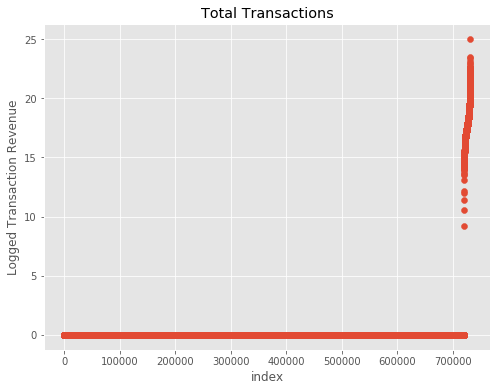

In [9]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype('float')
txns_by_users = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(txns_by_users.shape[0]), np.sort(np.log1p(txns_by_users["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('Logged Transaction Revenue', fontsize=12)
plt.title('Total Transactions')
plt.show()

The Kaggle competition that I am using started off with saying that 80% of the transactions come from 20% of the users, and this visualization seems to be in line with that logic. Let's take a look at the top users who spend the most.

In [10]:
txns_by_users.sort_values('totals.transactionRevenue', ascending = False).head(5)

,fullVisitorId,totals.transactionRevenue
182593,1957458976293878100,7.591669e+10
392626,5632276788326171571,1.602375e+10
610261,9417857471295131045,1.517012e+10
326192,4471415710206918415,1.121110e+10
355498,4984366501121503466,9.513900e+09


In [11]:
train.loc[train.fullVisitorId.isin(txns_by_users.sort_values('totals.transactionRevenue', ascending = False).head(5)['fullVisitorId'])].loc[~pd.isnull(train['totals.transactionRevenue'])].head(10)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
22500,Direct,20161110,4984366501121503466,1478792651,6,1478792651,Chrome,desktop,False,Chrome OS,...,NaN,32.0,5.382000e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
89918,Direct,20161130,4984366501121503466,1480527609,8,1480527609,Chrome,desktop,False,Chrome OS,...,NaN,30.0,6.970000e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
126655,Direct,20161018,4984366501121503466,1476808875,2,1476808875,Chrome,desktop,False,Chrome OS,...,NaN,22.0,2.740000e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
142416,Direct,20170410,4984366501121503466,1491864249,22,1491864249,Chrome,desktop,False,Chrome OS,...,NaN,43.0,4.597000e+07,NaN,(not set),True,NaN,(none),NaN,(direct)
249668,Direct,20170105,4984366501121503466,1483653271,14,1483653271,Chrome,desktop,False,Chrome OS,...,NaN,39.0,1.633420e+09,NaN,(not set),True,NaN,(none),NaN,(direct)
275470,Direct,20170620,4984366501121503466,1497998174,24,1497998174,Chrome,desktop,False,Chrome OS,...,NaN,26.0,7.310800e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
287213,Direct,20170728,9417857471295131045,1501255344,19,1501255344,Chrome,desktop,False,Windows,...,NaN,51.0,6.855200e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
339913,Direct,20170721,9417857471295131045,1500657634,10,1500657634,Chrome,desktop,False,Windows,...,NaN,76.0,1.064080e+09,NaN,(not set),True,NaN,(none),NaN,(direct)
348275,Display,20170601,1957458976293878100,1496342143,295,1496342143,Firefox,desktop,False,Windows,...,NaN,24.0,2.344000e+08,NaN,(not set),True,NaN,cpm,NaN,dfa
354592,Direct,20161027,4984366501121503466,1477584959,3,1477584959,Chrome,desktop,False,Chrome OS,...,NaN,43.0,2.904000e+08,NaN,(not set),True,NaN,(none),NaN,(direct)


From the sample above, it looks like top users use desktops to make transactions; however, their operating systems are quite diverse between Windows, Chrome, and Mac. There is still some hesitation that these could be affiliate companies or internal employees buying large amount of items for their teams, but this is something worth exploring.

In [12]:
not_null_rev = train.loc[~pd.isna(train['totals.transactionRevenue'])]['fullVisitorId'].count()
no_spend_customers = txns_by_users.loc[txns_by_users['totals.transactionRevenue'] > 0]['fullVisitorId'].count()
not_null_rev/train.shape[0], no_spend_customers/txns_by_users.shape[0]

(0.0127427231470487, 0.013976902495279737)

We note from above that out of all visitors visiting the Google Store, only 1.4% of visitors are revenue generating customers. 

*Note that this data begins from August 01 2016 and ends on August 01 2017

#### Device Category, Operating System, and Browser

In [13]:
train.groupby('device.deviceCategory')['totals.transactionRevenue']

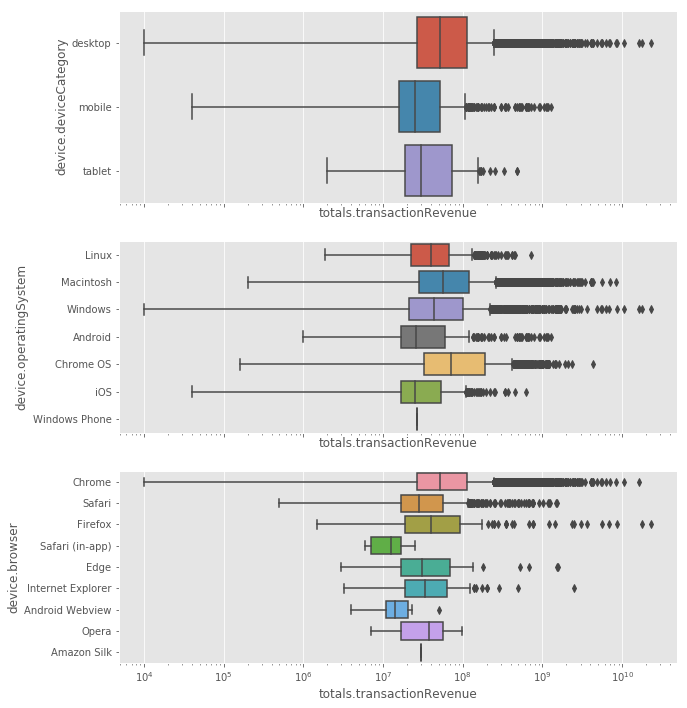

In [14]:
f, axes = plt.subplots(3, figsize=(10, 12), sharex=True)
for i, k in enumerate(['device.deviceCategory', 'device.operatingSystem', 'device.browser']):
#     tmp = train[[k, 'totals.transactionRevenue']]
#     tmp = tmp.loc[~pd.isnull(tmp['totals.transactionRevenue'])]
#     tmp['logged_val'] = tmp['totals.transactionRevenue'].apply(lambda x : np.log1p(x))
#     sns.boxplot(y=k, x="logged_val", data=tmp, dodge=False, ax=axes[i])
    sns.boxplot(y=k, x="totals.transactionRevenue", data=train.loc[~pd.isnull(train['totals.transactionRevenue'])], dodge=False, ax=axes[i])
    axes[i].set_xscale('log')

Above we see boxplots for device types, operating systems, and browsers of non-null transaction revenues. We note a few observations:
- The majority of customers use Desktops for purchases.
    - Surprisingly tablets are the second highest usage for purchases, followed by mobile phones.
- Chrome OS has the highest median spend at the Google store, this plays into my theory that it could be Google employees who are purchasing Google products.
- Unsurprisingly, Chrome had the highest median revenue of the web browsers; however, Firefox was a surprise in second place.

#### Potential Indirect Outcome: Page Views

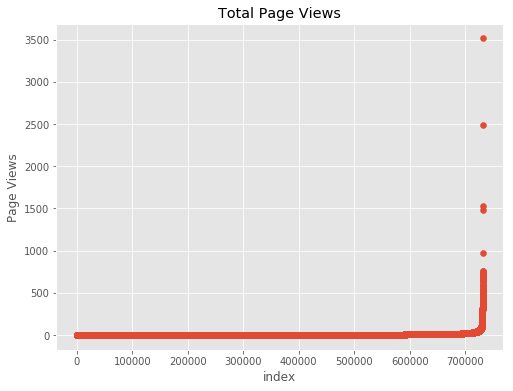

In [15]:
train['totals.pageviews'] = train['totals.pageviews'].astype('float')
pg_by_users = train.groupby("fullVisitorId")["totals.pageviews"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(pg_by_users.shape[0]), np.sort(pg_by_users["totals.pageviews"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Page Views', fontsize=12)
plt.title('Total Page Views')
plt.show()

We note the similarities between page views and total revenue, thus we can use page views as an indirect outcome because ultimately users need to view a page before purchasing a product. This allows us to switch our cluster methodology from: Recency, Frequency, and Monetary to Recency, Frequency, and Views.

### Feature Engineering

#### Recency Cluster

In [132]:
non_zero_txn = train.loc[pd.notnull(train['totals.transactionRevenue'])]

In [133]:
tx_user = pd.DataFrame(non_zero_txn['fullVisitorId'].unique())
tx_user.columns = ['fullVisitorId']

In [134]:
train['date_format'] = pd.to_datetime(train['date'], format="%Y%m%d")
tx_max_purchase = train.groupby('fullVisitorId').date_format.max().reset_index()
tx_max_purchase.columns = ['fullVisitorId','date_format']

tx_max_purchase['recency'] = (tx_max_purchase['date_format'].max() - tx_max_purchase['date_format']).dt.days

tx_user = pd.merge(tx_user, tx_max_purchase[['fullVisitorId','recency']], on='fullVisitorId')

In [135]:
tx_max_purchase.count()

fullVisitorId    731421
date_format      731421
recency          731421
dtype: int64

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


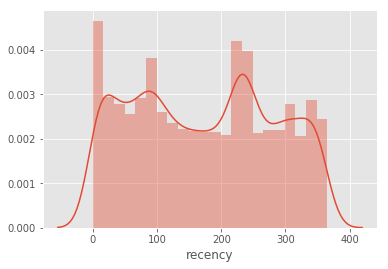

In [136]:
sns.distplot(tx_user['recency'])

In [137]:
tx_user.describe()

,recency
count,10223.000000
mean,173.245818
std,108.380458
min,0.000000
25%,78.000000
50%,175.000000
75%,261.000000
max,365.000000


We see that the median recency is 175 days, while the mean is close -- 173. We may be able to infer from the graph above that the median purchases were made between 261 and 175 days prior to August 1 2017, which is around from November 2016 to February 2017, which makes sense because this is around the holiday season.

In [138]:
from datetime import timedelta
datetime(2017,8,1) - timedelta(261)

datetime.datetime(2016, 11, 13, 0, 0)

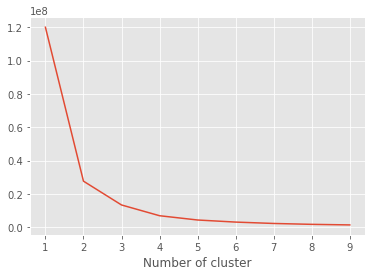

{1: 120070921.25873032,
 2: 27599295.841837794,
 3: 13294268.429974128,
 4: 6832606.570889071,
 5: 4260578.116659052,
 6: 3008921.0791957597,
 7: 2181768.3341162223,
 8: 1653431.7679139217,
 9: 1308480.1964049013}

In [139]:
from sklearn.cluster import KMeans

def plot_kmeans_inertia(feature):
    tmp = tx_user[[feature]]
    sse={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tmp)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    return sse
    
plot_kmeans_inertia('recency')

We see from the chart above that we can choose either 3 or 4 clusters. We will choose 4 just to have more features in our model. 

In [140]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(tx_user[['recency']])

## Save model to use for test as well
filename = '../feature_models/kmeans_recency.sav'
pickle.dump(kmeans, open(filename, 'wb'))

In [141]:
# def engineer_features(user_df, df, model_file, col_name):
#     mod1 = pickle.load(open(model_file, 'rb'))
#     user_df[col_name+"_cluster"] = mod1.predict(user_df[col_name])
#     df = pd.merge(df, user_df[['fullVisitorId']])   

In [142]:
model_file = filename
mod1 = pickle.load(open(model_file, 'rb'))
tx_user['recency_cluster'] = mod1.predict(tx_user[['recency']])

In [143]:
tx_user.groupby(['recency_cluster']).agg({'recency' : ['min', 'max', 'mean']})

recency                 
                    min  max        mean
recency_cluster                         
0                   274  365  320.169943
1                     0   78   35.267671
2                    79  174  122.097619
3                   175  273  226.275752

#### Frequency Cluster

In [144]:
tx_frequency = non_zero_txn.groupby('fullVisitorId').visitId.count().reset_index()

In [145]:
tx_frequency.columns = ['fullVisitorId','frequency']

In [146]:
tx_user = pd.merge(tx_user, tx_frequency, on='fullVisitorId')

In [147]:
tx_user.describe()

,recency,recency_cluster,frequency
count,10223.000000,10223.000000,10223.000000
mean,173.245818,1.575271,1.126382
std,108.380458,1.115771,0.625919
min,0.000000,0.000000,1.000000
25%,78.000000,1.000000,1.000000
50%,175.000000,2.000000,1.000000
75%,261.000000,3.000000,1.000000
max,365.000000,3.000000,29.000000


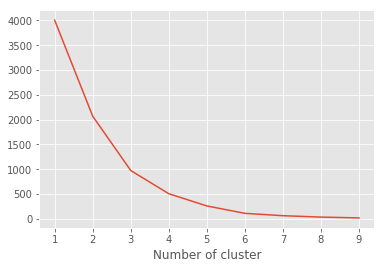

{1: 4004.7148586520593,
 2: 2069.2935283264683,
 3: 973.018450184502,
 4: 505.35468189715726,
 5: 259.240194975628,
 6: 109.59219269102991,
 7: 62.13346253229974,
 8: 34.2264239028945,
 9: 17.374074074074077}

In [148]:
plot_kmeans_inertia('frequency')

Our intertia graph above doesn't have a concrete elbow; however, I will select 5 clusters to have more variance in the feature space.

In [149]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(tx_user[['frequency']])

## Save model to use for test as well
filename = '../feature_models/kmeans_frequency.sav'
pickle.dump(kmeans, open(filename, 'wb'))
model_file = filename
mod1 = pickle.load(open(model_file, 'rb'))
tx_user['frequency_cluster'] = mod1.predict(tx_user[['frequency']])

In [151]:
tx_user.groupby(['frequency_cluster']).agg({'frequency' : ['min', 'max']})

frequency    
                        min max
frequency_cluster              
0                         1   1
1                         4   8
2                         9  16
3                         2   3
4                        29  29

#### Page View Cluster

In [153]:
tx_pv = non_zero_txn.groupby('fullVisitorId').agg({'totals.pageviews' : 'sum'}).reset_index()
tx_pv.columns = ['fullVisitorId','pg_views']
tx_user = pd.merge(tx_user, tx_pv, on='fullVisitorId')

In [154]:
tx_user.describe()

,recency,recency_cluster,frequency,frequency_cluster,pg_views
count,10223.000000,10223.000000,10223.000000,10223.000000,10223.000000
mean,173.245818,1.575271,1.126382,0.232417,31.910887
std,108.380458,1.115771,0.625919,0.792734,31.939338
min,0.000000,0.000000,1.000000,0.000000,2.000000
25%,78.000000,1.000000,1.000000,0.000000,17.000000
50%,175.000000,2.000000,1.000000,0.000000,24.000000
75%,261.000000,3.000000,1.000000,0.000000,37.000000
max,365.000000,3.000000,29.000000,4.000000,671.000000


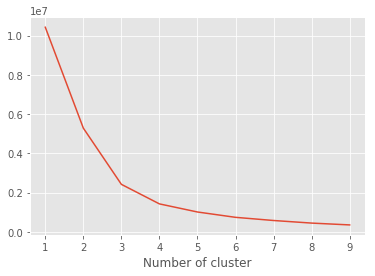

{1: 10427679.818252958,
 2: 5282271.50306487,
 3: 2415901.6304565934,
 4: 1419538.2049963013,
 5: 1006245.4196820487,
 6: 734201.7605694033,
 7: 572506.0052355207,
 8: 440536.93001583597,
 9: 347406.3919958332}

In [155]:
plot_kmeans_inertia('pg_views')

In [156]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(tx_user[['pg_views']])

## Save model to use for test as well
filename = '../feature_models/kmeans_pg_views.sav'
pickle.dump(kmeans, open(filename, 'wb'))
model_file = filename
mod1 = pickle.load(open(model_file, 'rb'))
tx_user['pg_views_cluster'] = mod1.predict(tx_user[['pg_views']])

In [157]:
tx_user.groupby(['pg_views_cluster']).agg({'pg_views' : ['min', 'max']})

pg_views       
                      min    max
pg_views_cluster                
0                     2.0   34.0
1                    79.0  233.0
2                   253.0  671.0
3                    35.0   78.0